In [1]:
#-------------------------------------------------------------------------------
# demo code to perform maximum likelihood analysis of
# radial velociy measurements between a spectrum and a
# given template, drawn from the BOSZ models
#-------------------------------------------------------------------------------
# Alex Szalay, 2021-10-05
# Alex Szalay, 2021-10-22   major cleanup, some modifications, tests added
# Alex Szalay, 2021-11-20   focus on Fisher Matrix, removed unrelated test code
#-------------------------------------------------------------------------------
import numpy as np
import scipy as sp
import os
import collections
import copy
import time
import urllib
import bz2
import h5py

import matplotlib.pyplot as plt
from scipy import stats
from numpy import linalg
from scipy.optimize import curve_fit

%matplotlib inline

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# set working directory (change it to your own) 
# to the location of this notebook
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
os.chdir('/home/idies/workspace/Storage/szalay/persistent/PFS/RV')

#---------------------------------------------------------------
# create ./figs and ./tmp subdirectories if they do not exist
#---------------------------------------------------------------
tpath = './figs'
if (not os.path.isdir(tpath)):
    os.mkdir(tpath)
    
tpath = './tmp'
if (not os.path.isdir(tpath)):
    os.mkdir(tpath)
    

In [2]:
#----------------------------------
# read all the parameter data
#----------------------------------
DATAPATH = '/home/idies/workspace/pfs/'
para = np.genfromtxt(DATAPATH+'para.csv', delimiter=',',skip_header=1)

MH    = para[:,5]
Teff  = para[:,6]
logG  = para[:,7]
CH    = para[:,8]
AH    = para[:,9]

uM = np.unique(MH)
uT = np.unique(Teff)
uG = np.unique(logG)
uC = np.unique(CH)
uA = np.unique(AH)

if (1==0):
    print('Teff:',uT)
    print('logG:',uG)
    print('M/H :',uM)
    print('ALP :',uA)
    print('C/H :',uC)

#--------------------------------------
# read the raw Mauna Kea sky spectrum
#--------------------------------------
sky = np.genfromtxt(DATAPATH+'skybg_50_10.csv', delimiter=',')
sky[:,0]= 10*sky[:,0]

#-----------------------------------
# create subdirectory for figures
#-----------------------------------
if (not os.path.isdir('./figs')):
    os.mkdir('./figs')
    

In [3]:
#-----------------------------------------------------------------------------------
# generate the url and the pathname from the parameters to download the spectra
# from the STScI website
#-----------------------------------------------------------------------------------
def fmt(x):
    y = np.round(np.abs(10*x)+0.2).astype(np.int32)
    z = '{:+03.0f}'.format(y).replace('+','p')
    if (np.sign(x)<0):
        z = z.replace('p','m')
    return z

def fmn(x):    
    return '{:02d}'.format(np.floor(x).astype(np.int32))

def ffm(x):
    return '{:+4.2f}'.format(x)   
    
def getfilename(m,c,a,t,g,R):
    #---------------------------------------
    # get the long filename for the website
    #---------------------------------------
    fname = 'am'+fmt(m)+'c'+fmt(c)+'o'+fmt(a)+'t'+fmn(t)+'g'\
        +fmn(10*g)+'v20modrt0b'+'{:d}'.format(R)+'rs.asc.bz2'
    return fname

def getname(m,c,a,t,g):
    #----------------------------------
    # get short name for the spectrum
    #----------------------------------
    fname = 'T'+fmn(t)+'G'+fmn(10*g)+'M'+fmt(m)+'A'+fmt(a)+'C'+fmt(c)
    return fname
    
def geturl(m,c,a,t,g,R):
    #----------------------------------------
    # build the url for the STScI site
    #----------------------------------------    
    url = 'https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_'+'{:06d}'.format(R)+'/'
    url = url + 'metal_'+ffm(m) + '/carbon_'+ffm(c) + '/alpha_'+ffm(a)
    url = url + '/'+ getfilename(m,c,a,t,g,R)
    return url

# example URL
#url = 'https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_020000/metal_-1.00/carbon_+0.00/alpha_+0.25/amm10cp00op03t10500g25v20modrt0b20000rs.asc.bz2'

#--------------------------
# get the data from a url
#--------------------------
def download_url(url, root, filename=None):
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
    """
    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    os.makedirs(root, exist_ok=True)

    try:
        urllib.request.urlretrieve(url, fpath)
    except (urllib.error.URLError, IOError) as e:
        if url[:5] == 'https':
            url = url.replace('https:', 'http:')
            print('Failed download. Trying https -> http instead.'
                    ' Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(url, fpath)

def getSpectrum(m,c,a,t,g):
    #-----------------------------------------------------------
    # get a spectrum given the 5 parameter values
    # Input:
    #   m : M/H
    #   c : C/H
    #   a : ALPHA/H
    #   t : Teff
    #   g : log g
    # Output:
    #   o[:,0] is the wavelength in \AA
    #   o[:,1] is the flux
    #   o[:,2] is the theoretical envelope
    #-----------------------------------------------------------
    # The spectrum extends a bit beyond the MR range
    #     6250 A < lambda < 9750 A
    # If the parameter values are not on the grid, returns an 
    # empty vector and writes an error message
    #-----------------------------------------------------------
    # set the resolution in the BOSZ convention, 
    # corresponding to R=100,000
    #-----------------------------------------------------------
    R = 50000
    #------------------------------------------------------
    # first check if the values are a valid grid location
    #------------------------------------------------------
    if (~isValidGrid(m,c,a,t,g)):
        print('Parameters are not on the grid')
        return np.zeros((1,3))
    #--------------------------------------
    # fbuild the url and fetch the data
    #--------------------------------------
    url = geturl(m,c,a,t,g,R)
    print(url)
    download_url(url,'tmp/','test.bz2')
    #
    filepath    = 'tmp/test.bz2'
    newfilepath = 'tmp/test.txt'
    #--------------------------
    # unzip the spectrum
    #--------------------------
    with open(newfilepath, 'w') as new_file, bz2.BZ2File(filepath, 'rb') as file:
        data = file.read().decode("utf-8") 
        new_file.write(data)
    d = np.genfromtxt(newfilepath, delimiter=' ')
    #----------------------------------------------------------------------
    # select the wavelength range for the medium resolution spectrograph
    #----------------------------------------------------------------------
    iw = (d[:,0]>=6250) & (d[:,0]<=9750)
    o  = d[iw,:]
    #
    return o

def isValidGrid(m,c,a,t,g):
    #----------------------------------------------------------
    # determine if the parameters are at a valid grid point
    #----------------------------------------------------------
    ix = (MH==m) & (CH==c) & (AH==a) & (Teff==t) & (logG==g)
    return ix.any()


In [4]:
#----------------------------------------------------------------------
# Basic bulding blocks for creating the spectra.
# These should be replaced with their proper PFS implementations.
# we are starting from BOSZ spectra with R=50,000, corresponding
# to lambda/dlambda = 100,000 per pixel.  We need to reduce this 
# to dlambda~0.4A, which is lambda/dlambda = 20,000, i.e. 5 h-pixels
# per m-pixel. One h-pixel is 3 km/s, and one m-pixel is 15 km/s.
#----------------------------------------------------------------------

def resampleSpec(spec, step=5):
    #-----------------------------------------------------
    # resample the spectrum by a factor step
    #-----------------------------------------------------
    c = np.cumsum(spec)
    b = list(range(1,spec.shape[0],step))
    db = np.diff(c[b])
    dd = (db/step)
    return dd

def resampleWave(wave,step=5):
    #-----------------------------------------------------
    # resample the wavelengths by a factor step
    # output values are geometric mean of the boundaries.
    #-----------------------------------------------------
    w = np.cumsum(np.log(wave))
    b = list(range(1,wave.shape[0],step))
    db = np.diff(w[b])
    dd = (db/step)
    return np.exp(dd)

def resampleSky(sky, ww, step=5):
    #-----------------------------------------------------
    # resample the sky matching the spectrum
    #-----------------------------------------------------
    # get the breakpoints in lambda
    #--------------------------------
    b = list(range(1,ww.shape[0],step))
    ws = sky[:,0]
    cs = np.cumsum(sky[:,1])
    #---------------------------------------------------
    # interpolate the cumulative sky to the breakpoints
    #---------------------------------------------------
    f = sp.interpolate.interp1d(ws,cs, fill_value=0)
    sky_new = np.diff(f(ww[b]))
    return sky_new

def convolveSpec(spec,step=5):
    #---------------------------------------------------------
    # apply a line spread function to the h-pixel spectrum
    # with a width of 1.3 m-pixels. This is using the log(lambda) 
    # binning in hirez.
    #---------------------------------------------------------
    sg = 1.3
    #-----------------------------------
    # create resampled kernel by step
    # precompute the kernel, if there are many convolutions
    #-----------------------------------
    xx = np.linspace(-7*step, 7*step, 14*step+1)
    yy = np.exp(-0.5*xx**2/sg**2)/np.sqrt(2*np.pi*sg**2)
    fspec = np.convolve(spec,yy,'same')
    return fspec

def shiftSpec(ss, rv):
    #--------------------------------------------------
    # The radial velocity rv is given in km/sec units
    # This must be done at the hirez pixel resolution
    #--------------------------------------------------
    ssobs = sp.ndimage.shift(ss,rv/3.0)
    return ssobs


In [5]:
#----------------------------------------------------------------------
# Utility functions to build the templates and the observations.
# These are simple mockups that will need to be replaced with real
# ones, that simulate the spectrograph.  
#-----------------------------------------------------------------------
# For the variance we use an ad-hoc linear combination of the spectrum,
# the sky and a uniform read noise. We use log lambda pixels for the MR, 
# needs to be changed, maybe to the real wavelength solution. For the
# convolution with the LSF we use here a constant Gaussian with a sigma
# of 1.3 MR pixels.
#------------------------------------------------------------------------

def getVar(ssm, skym):
    #--------------------------------------------
    # Get the total variance
    # BETA is the scaling for the sky
    # VREAD is the variance of the white noise
    # This variance is still scaled with an additional
    # factor when we simuate an observation.
    #--------------------------------------------
    BETA  = 10.0
    VREAD = 16000
    varm  = ssm + BETA*skym + VREAD
    return varm

def getModel(sconv,rv):
    #-----------------------------------------------------
    # Generate a spectrum shifted by rv. sconv is a high rez
    # spectrum already convolved with the LSF, rv is the 
    # radial velocity in km/s. Here we convolve once for speed, 
    # then apply different shifts and resample.
    #-----------------------------------------------------
    ss1 = shiftSpec(sconv,rv)
    ss1 = resampleSpec(ss1)    
    return ss1
    
def getNoise(varm):
    #--------------------------------------------------------
    # given the noise variance, create a noise realization
    # using a Gaussian approximation
    # Input
    #  varm: the variance in m-pixel resolution
    # Output
    #  noise: nosie realization in m-pixels
    #--------------------------------------------------------
    noise = np.random.normal(0, 1, len(varm))*np.sqrt(varm)
    return noise

def getObs(sconv,skym,rv,NL):
    #----------------------------------------------------
    # get a noisy spectrum for a simulated observation
    #----------------------------------------------------
    # inputs
    #   sconv: the rest-frame spectrum in h-pixels, convolved
    #   skym: the sky in m-pixels
    #   rv  : the radial velocity in km/s
    #   NL  : the noise amplitude
    # outputs
    #   ssm : the shifted, resampled sepectrum in m-pix
    #   varm: the variance in m-pixels
    #-----------------------------------------------
    # get shifted spec and the variance
    #-----------------------------------------------
    ssm   = getModel(sconv,rv)
    varm  = getVar(ssm,skym)
    noise = getNoise(varm)  
    #---------------------------------------
    # add the scaled noise to the spectrum
    #---------------------------------------
    ssm = ssm + NL*noise
    return ssm

def getSN(spec):
    #--------------------------------------------------
    # estimate the S/N using Stoehr et al ADASS 2008
    #    signal = median(flux(i))
    #    noise = 1.482602 / sqrt(6.0) *
    #    median(abs(2 * flux(i) - flux(i-2) - flux(i+2)))
    #    DER_SNR = signal / noise
    #--------------------------------------------------
    s1 = np.median(spec)
    s2 = np.abs(2*spec-sp.ndimage.shift(spec,2)-sp.ndimage.shift(spec,-2))
    n1 = 1.482602/np.sqrt(6.0)*np.median(s2)
    sn = s1/n1
    return sn


In [6]:
#--------------------------------------------------------------------------------
# Assemble the components of the template needed for the likelihood analysis
# into a named tuple, for easy parameter passing
#--------------------------------------------------------------------------------
Template = collections.namedtuple('Template',['name','sst','wwm','ssm','skym','pmt','iwm'])

def makeTemplate(m,c,a,t,g):
    #-----------------------------------------------
    # get the spectrum (n) and build the template
    #-----------------------------------------------
    name = getname(m,c,a,t,g)
    pmt  = (m,c,a,t,g)
    o    = getSpectrum(m,c,a,t,g)
    ww   = o[:,0]
    sst  = o[:,1]
    sst  = convolveSpec(sst)
    
    wwm  = resampleWave(ww)
    ssm  = resampleSpec(sst)
    skym = resampleSky(sky,ww)
    iwm  = (wwm>=7100) & (wwm<=8850)
    temp = Template(name,sst,wwm,ssm,skym,pmt,iwm)
    
    return temp

def makeNLArray(ss,pmt,temp):
    #-----------------------------------------
    # choose the noise levels so that the S/N 
    # comes at around the predetermined levels
    #-----------------------------------------
    nla = [2,5,10,20,50,100,200,500]
    sna = [11,22,33,55,110]
    
    ssm   = getModel(ss,0)
    varm  = getVar(ssm,temp.skym)
    noise = getNoise(varm)  
    NL = []
    SN = []
    for nl in nla:
        ssobs = ssm + nl*noise
        sn    = getSN(ssobs)
        NL.append(nl)
        SN.append(sn)
    f = sp.interpolate.interp1d(SN,NL, fill_value=0)
    nlarray = f(sna)
    
    return nlarray


In [7]:
#----------------------------------------------------------
# testing functions for TEST 1-2 to plot the LLH as a function of rv
#----------------------------------------------------------
def showRV(rv, RV, ssobs, temp):
    
    v1  = np.linspace(-300, 300,101)
    v2  = np.linspace(rv-6, rv+6,25)
    
    y1 = []
    y2 = []
    for v in v1:
        y1.append(-llh(v,ssobs,temp))
    for v in v2:
        y2.append(-llh(v,ssobs,temp))
        
    SN = getSN(ssobs)
    
    plt.figure(figsize=(15,6))
    plt.plot(v1,y1,'g.-',markersize=7)    
    plt.plot(rv,-llh(rv,ssobs,temp),'ro')
    plt.plot(RV,-llh(RV,ssobs,temp),'ko')
    plt.title('rv={:6.4f} km/s,  '.format(rv)+ 'RV={:6.4f} km/s,  '.format(RV)+'S/N={:3.1f},'.format(SN))
    plt.grid()
    plt.ylim((min(y1),max(y1)+250))
    plt.legend(['llh','rv(true)','RV(est)'])
    ax = plt.gca()
    ins = ax.inset_axes([0.1,0.45,0.4,0.5])
    ins.plot(v2,y2,'g.-',markersize=7)
    ins.plot(rv,-llh(rv,ssobs,temp),'ro')
    ins.plot(RV,-llh(RV,ssobs,temp),'ko')
    ins.grid()
    
    plt.savefig('figs/F-rvfit.png');
    plt.show()
    
def showSpec(wwm,ssm, sso):
    #------------------------------------
    # show the input spectrum as well
    # as the noisy version
    #------------------------------------
    SN = getSN(sso)
    plt.figure(figsize=(15,4))
    plt.plot(wwm, sso, lw=0.2)
    plt.plot(wwm,ssm,lw=1)
    plt.title(sname+'    S/N={:5.1f}'.format(SN))
    plt.savefig('figs/F-rvspec.png')
    plt.show()   

def testOneRV(ss,temp,rv,NL,plot=1):
    ssm   = getModel(ss,rv)
    wwm   = temp.wwm
    varm  = getVar(ssm,temp.skym)
    noise = getNoise(varm)  
    ssobs = ssm + NL*noise
    SN    = getSN(ssobs)
    RV    = getRV(ssobs,temp)

    if (plot==1):
        showSpec(wwm,ssm,ssobs)
        showRV(rv, RV, ssobs, temp)
    else:
        print('SN=',SN, 'RV=',RV)
    return RV

def  showRVGuess(ssobs,temp,rv):
    #-------------------------------------------
    # show the shape of the likelihood function
    # with the coarse Lorentzian fit and the 
    # final estimator. The Lorentz fit runs inside
    # the getRV function as well.
    #-------------------------------------------
    v0  = np.linspace(-500, 500,11)
    v1  = np.linspace(-500, 500,501)    
    v2  = np.linspace(rv-6, rv+6,25)
    
    y0 = []
    y1 = []
    y2 = []
    for v in v0:
        y0.append(-llh(v,ssobs,temp))
    for v in v1:
        y1.append(-llh(v,ssobs,temp))
    for v in v2:
        y2.append(-llh(v,ssobs,temp))        
    
    #-------------------------------------
    # do the Lorentz fit on the 11 points
    #-------------------------------------
    pp = [200,0,100,0.5*(y1[0]+y1[-1])]
    bb=((100,-300,100,min(y1)),(500,300,300,max(y1)))
    pp, pcov = curve_fit(lorentz, v0, y0, pp, bounds=bb)
    vv = v1
    yy = lorentz(vv,*pp)
    #--------------------------------------------------
    # evaluate the fit at the maximum
    #--------------------------------------------------
    VV = pp[1]
    YY = pp[0]+pp[3]
    
    SN = getSN(ssobs)
    RV = getRV(ssobs,temp)

    plt.figure(figsize=(15,6))
    plt.plot(v0,y0,'mo',markersize=7)
    plt.plot(v1,y1,'r-',markersize=7,lw=1)    
    plt.plot(rv,-llh(rv,ssobs,temp),'ro')
    plt.plot(RV,-llh(RV,ssobs,temp),'ko')
    
    #plt.plot(vv,yy,'k')
    plt.plot(VV,YY,'g*',markersize=12)
    
    plt.title('rv={:6.4f} km/s,  '.format(rv)+ 'RV={:6.4f} km/s,  '.format(RV)+'S/N={:3.1f}'.format(SN))
    plt.grid()
    plt.ylim((min(y1),max(y1)+250))
    plt.legend(['llh','llh(full)','RV(est)'])
    plt.plot(vv,yy)

    ax = plt.gca()
    ix = 0.1
    iy = 0.45
    if (RV<0):
        ix=0.5
    ins = ax.inset_axes([ix,iy,0.4,0.5])
    ins.plot(v2,y2,'g.-',markersize=7)
    ins.plot(rv,-llh(rv,ssobs,temp),'ro')
    ins.plot(RV,-llh(RV,ssobs,temp),'ko')
    ins.grid()
        
    plt.savefig('figs/F-rvguess.png');    
    plt.show()

def getLLHGrid(rv,ssobs,temp):
    #------------------------------------------------
    # evaluate the LLH in a grid around the true rv
    #------------------------------------------------
    v1 = np.floor(rv)-10
    v2 = np.floor(rv)+10
    vv = np.linspace(v1,v2,21)
    LLH = []
    for v in vv:
        nu = llh(rv,ssobs,temp)
        LLH.append(-nu)
    return LLH


In [8]:
#------------------------------------------------
# Different ways to evaluate the Fisher matrix
# The best is getFisher2
#------------------------------------------------
def getFisher1(rv,sobs,vobs,t):
    #---------------------------
    # compute the Fisher matrix
    #---------------------------
    m0 = getModel(t.sst,rv)
    m2 = getModel(t.sst,rv+1)
    m1 = getModel(t.sst,rv-1)
    #---------------------------------
    # clip to the spectrograph range
    #---------------------------------
    t0  = m0[t.iwm]
    #-----------------------------
    # get the centered difference
    #-----------------------------
    t1  = 0.5*(m2[t.iwm]-m1[t.iwm])
    vm  = vobs[t.iwm]
    obs = sobs[t.iwm]
    #----------------------------------
    # build the different terms
    #----------------------------------
    psi00 = np.sum(t0*t0/vm)
    psi01 = np.sum(t0*t1/vm)
    psi11 = np.sum(t1*t1/vm)
    phi   = np.sum(obs*t0/vm)
    chi   = np.sum(t0*t0/vm)    
    a0    = phi/chi
    dpsi  = psi00*psi11-psi01**2
    sigz2 = psi00/a0**2/dpsi
    return sigz2


def getFisherMatrix1(rv,sobs,vobs,temp):
    #---------------------------
    # compute the Fisher matrix
    #---------------------------
    m0 = getModel(temp.sst,rv)
    m2 = getModel(temp.sst,rv+1)
    m1 = getModel(temp.sst,rv-1)
    #---------------------------------
    # clip to the spectrograph range
    #---------------------------------
    iwm = temp.iwm
    t0  = m0[iwm]
    #-----------------------------
    # get the centered difference
    #-----------------------------
    t1  = 0.5*(m2[iwm]-m1[iwm])
    vm  = vobs[iwm]
    obs = sobs[iwm]
    #plt.plot(obs,'b-',lw=0.2)
    #plt.plot(t0,'r-',lw=1)
    #----------------------------------
    # build the different terms
    #----------------------------------
    psi00 = np.sum(t0*t0/vm)
    psi01 = np.sum(t0*t1/vm)
    psi11 = np.sum(t1*t1/vm)
    phi   = np.sum(obs*t0/vm)
    chi   = np.sum(t0*t0/vm)    
    a0    = phi/chi
    dpsi  = psi00*psi11-psi01**2
    sigz2 = psi00/a0**2/dpsi
    F  = [[psi00,a0*psi01],[a0*psi01,a0**2*psi11]]
    return F


def getFisherMatrix2(rv,sobs,vobs,temp):
    #---------------------------
    # compute the Fisher matrix
    #---------------------------
    m0 = getModel(temp.sst,rv)
    m2 = getModel(temp.sst,rv+1)
    m1 = getModel(temp.sst,rv-1)
    #---------------------------------
    # clip to the spectrograph range
    #---------------------------------
    iwm = temp.iwm
    t0  = m0[iwm]
    t1  = m1[iwm]
    t2  = m2[iwm]
    vm  = vobs[iwm]
    s0  = sobs[iwm]
    #-----------------------------
    # get the centered difference
    #-----------------------------
    d1  = 0.5*(t2-t1)
    d2  = (t1+t2-2*t0)
    #----------------------------------
    # build the different terms
    #----------------------------------
    psi00 = np.sum(t0*t0/vm)
    psi01 = np.sum(t0*d1/vm)
    psi11 = np.sum(d1*d1/vm)
    psi02 = np.sum(t0*d2/vm)
    phi02 = np.sum(s0*d2/vm)
    phi00 = np.sum(s0*t0/vm)
    chi   = psi00 
    a0    = phi00/psi00
    F00 = psi00
    F01 = a0*psi01
    F11 = a0**2*(psi02-phi02/a0+psi11)
    F  = [[F00,F01],[F01,F11]]
    return F


def getFisherMatrix(rv,sobs,vobs,temp):
    #---------------------------
    # compute the Fisher matrix
    #---------------------------
    nu0,phi0,chi0 = llh1(rv,sobs,vobs,temp)
    num,phim,chim = llh1(rv-1,sobs,vobs,temp)
    nup,phip,chip = llh1(rv+1,sobs,vobs,temp)
    f00 = chi0
    f01 = 0.5*(phip-phim)
    f11 = phi0/chi0*(phip+phim-2*phi0)+0.5*phi0**2*(chip+chim-2*chi0)/chi0**2
    F = [[f00, f01],[f01,f11]]
    return F

def getFisherMatrix0(rv,sobs,vobs,temp):
    #---------------------------
    # compute the Fisher matrix
    #---------------------------
    nu0,phi0,chi0 = llh1(rv,sobs,vobs,temp)
    num,phim,chim = llh1(rv-1,sobs,vobs,temp)
    nup,phip,chip = llh1(rv+1,sobs,vobs,temp)
    f00 = chi0
    f01 = 0.5*(phip-phim)
    f11 = -nu0*(nup+num-2*nu0)+f01**2/chi0
    F = [[f00, f01],[f01,f11]]
    return F


In [9]:
def showSpec(wwm,ssm, sso):
    #------------------------------------
    # show the input spectrum as well
    # as the noisy version
    #------------------------------------
    SN = getSN(sso)
    plt.figure(figsize=(15,4))
    plt.plot(wwm, sso, lw=0.2)
    plt.plot(wwm,ssm,lw=1)
    plt.title(sname+'    S/N={:5.1f}'.format(SN))
    plt.savefig('figs/F-rvspec.png')
    plt.show() 
    
def lorentz(x, a,b,c,d):
    return a/(1+(x-b)**2/c**2) + d

def makeRVGuess(ssobs,vmobs,temp):
    #--------------------
    # get initial guess
    #--------------------
    v0  = np.linspace(-500, 500, 31)
    y0 = []
    for v in v0:
        y0.append(-llh0(v,ssobs,vmobs,temp))
    pp = [200,0,100,0.5*(y0[0]+y0[-1])]
    bb=((0,-300,100,min(y0)),(5000,300,300,min(y0)+4*(max(y0)-min(y0))))
    pp, pcov = curve_fit(lorentz, v0, y0, pp, bounds=bb)
    
    return pp[1]


def llh0(rv,sobs,varm,t):
    nu,phi,chi = llh1(rv,sobs,varm,t)
    return -nu

def llh1(rv,sobs,varm,t):
    #--------------------------------------------------
    # A variant of the log likelihood for the model fitting.
    # Also returns phi and chi for the Fisher matrix,
    # not to be used for the rv fitting, but rather for 
    # testing and error estimation.
    #--------------------------------------------------
    # Input
    #  rv : radial velocity in km/s
    #  sobs: the observed noisy spectrum
    #  varm: the variance of the observed data
    #  ss : noiseless template spectrum in h-pix
    #  t  : template array with columns (wwm,ssm,skym)
    # Output
    #  nu: the negative log likelihood, to be minimized
    # phi:  the cross term in the llh
    # chi:  the model^2 term in the llh
    #--------------------------------------------------
    # build the resampled, shifted template and variance
    # from the observed spectrum 
    #------------------------------------
    m = getModel(t.sst,rv)  
    #---------------------------------
    # clip to the spectrograph range
    #---------------------------------
    tm  = m[t.iwm]
    vm  = varm[t.iwm]
    obs = sobs[t.iwm]
    #----------------------------------
    # build the significance function
    #----------------------------------
    phi = np.sum(obs*tm/vm)
    chi = np.sum(tm*tm/vm)
    nu  = phi/np.sqrt(chi)    
    return nu,phi,chi


def testOneRV1(ss,temp,rv,NL,plot=1):
    ssm   = getModel(ss,rv)
    wwm   = temp.wwm
    varm  = getVar(ssm,temp.skym)
    noise = getNoise(varm)  
    ssobs = ssm + NL*noise
    vmobs = varm*NL**2
    SN    = getSN(ssobs)
    RV    = getRV1(ssobs,vmobs,temp)

    F     = getFisherMatrix(RV,ssobs,vmobs,temp)
    det   = F[0][0]*F[1][1]-F[1][0]**2
    print('sigma_z=',np.sqrt(F[0][0]/det))
    
    if (plot==1):
        showSpec(wwm,ssm,ssobs)
        showRV1(rv, RV, ssobs,vmobs, temp)
    else:
        print('SN=',SN, 'RV=',RV)
    return RV, F

#----------------------------------------------------------
# testing functions for TEST 1-2 to plot the LLH as a function of rv
#----------------------------------------------------------
def showRV1(rv, RV, ssobs,vmobs,temp):
    
    v1  = np.linspace(-300, 300,101)
    v2  = np.linspace(rv-6, rv+6,25)
    
    y1 = []
    y2 = []
    for v in v1:
        y1.append(-llh0(v,ssobs,vmobs,temp))
    for v in v2:
        y2.append(-llh0(v,ssobs,vmobs,temp))
        
    SN = getSN(ssobs)
    sigz2 = getFisher1(rv,ssobs,vmobs,temp)

    plt.figure(figsize=(15,6))
    plt.plot(v1,y1,'g.-',markersize=7)    
    plt.plot(rv,-llh0(rv,ssobs,vmobs,temp),'ro')
    plt.plot(RV,-llh0(RV,ssobs,vmobs,temp),'ko')
    ts = 'rv={:6.4f} km/s,  '.format(rv)+ 'RV={:6.4f} km/s,  '.format(RV)
    ts = ts + 'S/N={:3.1f},  '.format(SN) + 'sigz={:6.4f} km/s,  '.format(np.sqrt(sigz2))
    plt.title(ts)
    plt.grid()
    plt.ylim((min(y1),min(y1)+(max(y1)-min(y1))*1.5))
    plt.legend(['llh','rv(true)','RV(est)'])
    ax = plt.gca()
    ins = ax.inset_axes([0.1,0.45,0.4,0.5])
    ins.plot(v2,y2,'g.-',markersize=7)
    ins.plot(rv,-llh0(rv,ssobs,vmobs,temp),'ro')
    ins.plot(RV,-llh0(RV,ssobs,vmobs,temp),'ko')
    ins.grid()
    
    plt.savefig('figs/F-rvfit.png');
    plt.show()
    

def getFisher1(rv,sobs,vobs,t):
    #---------------------------
    # compute the Fisher matrix
    #---------------------------
    m0 = getModel(t.sst,rv)
    m2 = getModel(t.sst,rv+1)
    m1 = getModel(t.sst,rv-1)
    #---------------------------------
    # clip to the spectrograph range
    #---------------------------------
    t0  = m0[t.iwm]
    #-----------------------------
    # get the centered difference
    #-----------------------------
    t1  = 0.5*(m2[t.iwm]-m1[t.iwm])
    vm  = vobs[t.iwm]
    obs = sobs[t.iwm]
    #----------------------------------
    # build the different terms
    #----------------------------------
    psi00 = np.sum(t0*t0/vm)
    psi01 = np.sum(t0*t1/vm)
    psi11 = np.sum(t1*t1/vm)
    phi   = np.sum(obs*t0/vm)
    chi   = np.sum(t0*t0/vm)    
    a0    = phi/chi
    dpsi  = psi00*psi11-psi01**2
    sigz2 = psi00/a0**2/dpsi
    return sigz2


def getFisherMatrix(rv,sobs,vobs,temp):
    #---------------------------
    # compute the Fisher matrix
    #---------------------------
    nu0,phi0,chi0 = llh1(rv,sobs,vobs,temp)
    num,phim,chim = llh1(rv-1,sobs,vobs,temp)
    nup,phip,chip = llh1(rv+1,sobs,vobs,temp)
    f11 = chi0
    f12 = 0.5*(phip-phim)
    f22 = - nu0*(nup+num-2*nu0)+ f12**2
    F = [[f11, f12],[f12,f22]]
    return F


def getRV1(sso,vmo,tm):
    #------------------------------------------------------
    # fit the radial velocity. 
    # Test for the success of the minimization
    # Return nan, if error
    #------------------------------------------------------
    rv0 = makeRVGuess(sso,vmo,tm)
    #print('guess:',rv0)
    out = sp.optimize.minimize(llh0,rv0,  args=(sso,vmo,tm), method="Nelder-Mead")
    if (out.success==True):
        RV = out.x[0]
    else:
        print('getRV error in '+tm.name)
        RV = np.nan
    return RV


In [13]:
#-------------------------------------------------------------------
# helper functions for TEST 3-4 to assemble arrays of templates 
# in various configurations on the model grid
#-------------------------------------------------------------------
def getAdjacentGridPoints(pmt,rng,step=1):
    #----------------------------------------------------------------------
    # from the spectrum's parameters, build a list of adjacent grid points
    # along each axis. 'step' is how far to we want to go 
    #----------------------------------------------------------------------
    ups = ('uM','uC','uA','uT','uG')
    
    pt = [list(pmt)]
    #rng = range(len(pmt))

    for n in rng:
        #-----------------------------------------
        # build a set of neighboring grid points
        #-----------------------------------------
        p1 = list(pmt)
        p2 = list(pmt)
        #----------------------------------------
        # get grid location of current parameter    
        #----------------------------------------
        var = eval('ups['+str(n)+']')
        ix  = eval(var+'=='+str(pmt[n]))
        nx  = np.where(ix)[0][0]
        #---------------------------------
        # get adjacent values and update
        #---------------------------------
        v1 = eval(var+'['+str(nx-step)+']')
        v2 = eval(var+'['+str(nx+step)+']')
        p1[n] = v1
        p2[n] = v2
        #-------------------------------------------
        # test if this is still valid, and append
        #-------------------------------------------
        if (isValidGrid(*p1)):
            pt.append((p1))
        if (isValidGrid(*p2)):
            pt.append((p2))
    
    return pt

def get2DGrid(pmt, rng=[3,4], step=1):
    #----------------------------------------------------------------------
    # from the spectrum's parameters, build a list of adjacent grid points
    # in 2D slices. step is the number of grid points left and right. step=2
    # will give a 5x5 array of templates. rng is the index of the two parameters
    # defining the planar cut throught the parameter space frpom the array ups below.
    # E.g. Teff-Log_g is [3,4], or Teff-[M/H] is [3,0]
    #----------------------------------------------------------------------
    ups = ('uM','uC','uA','uT','uG')
    print(rng)
    
    pt = []
    n = [0,0,0]
    for n[0] in range(-step,step+1):
        for n[1] in range(-step,step+1):
            #-----------------------------------------
            # build a set of neighboring grid points
            #-----------------------------------------
            p1 = list(pmt)
            p2 = list(pmt)
            #----------------------------------------
            # get grid location of current parameter    
            #----------------------------------------
            for r in range(len(rng)):
                nr = rng[r]
                var = eval('ups['+str(nr)+']')
                ix  = eval(var+'=='+str(pmt[nr]))
                nx  = np.where(ix)[0][0]
                #---------------------------------
                # get adjacent values and update
                #---------------------------------
                v1 = eval(var+'['+str(nx-n[r])+']')
                p1[nr] = v1
                #-------------------------------------------
                # test if this is still valid, and append
                #-------------------------------------------
            if (isValidGrid(*p1)):
                pt.append((p1))
    
    return pt

def get3DGrid(pmt, rng=[0,3,4], step=1):
    #----------------------------------------------------------------------
    # from the spectrum's parameters, build a list of adjacent grid points
    # in 2D slices. step is the number of grid points left and right. step=2
    # will give a 5x5 array of templates. rng is the index of the two parameters
    # defining the planar cut throught the parameter space frpom the array ups below.
    # E.g. Teff-Log_g is [3,4], or Teff-[M/H] is [3,0]
    #----------------------------------------------------------------------
    ups = ('uM','uC','uA','uT','uG')
    print(rng)    
    pt = []
    n = [0,0,0]
    for n[0] in range(-step,step+1):
        for n[1] in range(-step,step+1):
            for n[2] in range(-step,step+1):
                #-----------------------------------------
                # build a set of neighboring grid points
                #-----------------------------------------
                p1 = list(pmt)
                p2 = list(pmt)
                #----------------------------------------
                # get grid location of current parameter    
                #----------------------------------------
                for r in range(len(rng)):
                    nr = rng[r]
                    var = eval('ups['+str(nr)+']')
                    ix  = eval(var+'=='+str(pmt[nr]))
                    nx  = np.where(ix)[0][0]
                    #---------------------------------
                    # get adjacent values and update
                    #---------------------------------
                    v1 = eval(var+'['+str(nx-n[r])+']')
                    p1[nr] = v1
                    #-------------------------------------------
                    # test if this is still valid, and append
                    #-------------------------------------------
                if (isValidGrid(*p1)):
                    pt.append((p1))
    
    return pt
RVSim = collections.namedtuple('RVSim',['name','N','NT','rv','RV','SN','S2','X2'])

def getSigmaSim(NL,NV,N,NT,ss,T):
    #--------------------------------------------
    # create simulations of the analysis
    # estimate sigma from the data, and 
    # return a normalized variate (rv-RV)/sig
    # NL:  noise level
    # NV:  number of random velocities
    # N :  number of independent realizations
    # NT:  index of template from the stencil
    # ss:  the high resolution spectrum
    # T :  the template array over the stencil
    # Returns:
    # S : list of simulation outputs, one item for each rv
    #--------------------------------------------
    rvarr  = 200*(np.random.rand(NV)-0.5)
    temp  = T[NT]
    #
    S = []
    for rv in rvarr:
        ssm   = getModel(ss,rv)
        wwm   = temp.wwm
        varm  = getVar(ssm,temp.skym)
        vmobs = NL**2*varm

        RV = []
        SN = []
        A2 = []
        S2 = []
        X2 = []

        for n in range(N):
            ssobs = ssm + getNoise(vmobs)    
            sn  = getSN(ssobs) 
            rvo = getRV1(ssobs,vmobs,temp)
            F2  = getFisherMatrix2(rvo,ssobs,vmobs,temp)
            iF2 = sp.linalg.inv(F2)
            sa2 = iF2[0,0]
            sg2 = iF2[1,1]

            RV.append(rvo)
            SN.append(sn)
            A2.append(sa2)
            S2.append(sg2)
            X2.append((rvo-rv)/np.sqrt(sg2))

        sim = RVSim(name,N,NT,rv,np.array(RV)-rv,SN,S2,X2)
        S.append(sim)

    return S

def mergeSims(S):
    name = S[0].name
    N  = S[0].N
    NT = S[0].NT
    rv = []
    RV = []
    SN = []
    A2 = []
    S2 = []
    X2 = []    
    for s in S:
        rv.append(s.rv)
        RV.append(s.RV)
        SN.append(s.SN)
        S2.append(s.S2)
        X2.append(s.X2)                
    sim = RVSim(name,N,NT,rv,RV,SN,S2,X2)
    return sim

def showSigmaHisto(s):
    rv = s.rv
    if (type(s.rv)==type([0,1])):
        rv = 0
    
    drv = np.mean(s.RV)
    srv = np.std(s.RV)
    sn0 = np.mean(s.SN)
    sg0 = np.sqrt(np.mean(s.S2))

    plt.figure(figsize=(12,6))
    nbins = 30
    bins = np.linspace(-3,3,nbins+1)
    #plt.hist(X2,bins,alpha=0.25)
    if (s.N==len(s.X2)):
        plt.hist(s.X2,bins)
    else:
        for x2 in s.X2:
            plt.hist(x2,bins, alpha=0.35)
    x = np.linspace(-3,3,31)
    y = s.N*6/nbins*np.exp(-0.5*x**2)/np.sqrt(2*np.pi)
    ts = s.name+'    '
    #ts = ts + '  rv={:6.3f} km/s,  '.format(rv)
    ts = ts + 'dRV={:6.4f}+/-'.format(drv)
    ts = ts + '{:6.4f} km/s,  '.format(srv)
    ts = ts + 'sigz={:6.4f} km/s,  '.format(sg0)
    ts = ts + 'S/N={:3.1f}  '.format(sn0)
    plt.plot(x,y)
    plt.title(ts)
    plt.xlabel('sigma')
    plt.ylabel('N')
    fname = 'figs/F-sigmahisto-'+s.name+'-SNR{:03d}.png'.format(np.int(sn0))
    plt.savefig(fname)
    plt.show()


def getSigmaTemplate(rv,nlarr,ss,T):
    ssm = getModel(ss,rv)
    wwm = T[4].wwm
    varm= getVar(ssm,T[4].skym)

    Q = []
    for temp in T:
        Q.append(temp.name)

    O = []
    for NL in nlarr:
        vmobs = NL**2*varm
        ssobs = ssm + getNoise(vmobs)    
        sn  = getSN(ssobs) 
        for NT in range(len(T)):
            temp  = T[NT]
            rvo = getRV1(ssobs,vmobs,temp)
            F2  = getFisherMatrix2(rvo,ssobs,vmobs,temp)
            iF2 = sp.linalg.inv(F2)
            sg2 = iF2[1,1]
            O.append((rv,sn,NT,rvo,np.sqrt(sg2)))

    O = np.array(O)
    name = T[4].name
    fname1 = 'csv/'+name+'-sigma.csv'
    fname2 = 'csv/'+name+'-names.csv'
    np.savetxt(fname1, O, delimiter=",",fmt="%10.6f")
    np.savetxt(fname2, Q, delimiter=",",fmt="%s")
    return O

In [11]:
##########################################################
# get the spectrum to be analyzed (m,c,a,t,g)
##########################################################
#pmt  = [-1.5,0.0,0.25,4250,1.0] # Dwarf G     -- done
#pmt  = [-2.0,0.0,0.25,4750,2.5] # M31 Giants  -- 
#pmt  = [-1.0,0.0,0.25,4750,4.0] # MW Warm MS  -- 
#pmt  = [-0.5,0.0,0.25,6000,2.5] # Red HB      -- done
#pmt  = [-1.0,0.0,0.25,6500,4.0] # MW Cool MS  --
pmt  = [-2.0,0.0,0.25,8000,2.5] # Blue HB     -- 

sname= getname(*pmt)
o    = getSpectrum(*pmt)
temp = makeTemplate(*pmt)
ww   = o[:,0]
ss   = o[:,1]
ss   = convolveSpec(ss)
skym = resampleSky(sky,ww)
rvarr = 200*(np.random.rand(5)-0.5)
nlarr = makeNLArray(ss,pmt,temp)

##########################################
# Now ready to launch the 1D or 2D tests
##########################################

https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8000g25v20modrt0b50000rs.asc.bz2
https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8000g25v20modrt0b50000rs.asc.bz2


In [12]:
############################################################
#  Build a 2D grid of nearby templates
#-----------------------------------------------------------
# Pick a spectrum (pmt), load in a 2D grid of templates around it
############################################################ 
carr = ['P','Q','R','S','Z']
cm = ['PM','QM','RM','SM','ZM']

name  = getname(*pmt)

#-------------------------------------------------
# create ./2D subdirectory if it does not exist
#-------------------------------------------------
tpath = './2D'
if (not os.path.isdir(tpath)):
    os.mkdir(tpath)
       
#----------------------------------------
# prepare the spectrum and the variance
#----------------------------------------
ssm  = getModel(ss,0)
varm = getVar(ssm,temp.skym)

#------------------------------------------------
# set the 2D plane [0..1] and N
#-----------------------------------------------
step = 1
#----------------------------------
# generate a 2D array of templates 
#----------------------------------
# Teff - log g
px = [3,4]
#----------------
T = []
temps = get2DGrid(pmt,px,step)
for p in temps:
    t = makeTemplate(*p)
    T.append(t)


[3, 4]
https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8250g30v20modrt0b50000rs.asc.bz2
https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8250g25v20modrt0b50000rs.asc.bz2
https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8250g20v20modrt0b50000rs.asc.bz2
https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8000g30v20modrt0b50000rs.asc.bz2
https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8000g25v20modrt0b50000rs.asc.bz2
https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8000g20v20modrt0b50000rs.asc.bz2
https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+

sigma_z= 0.2653314033369352


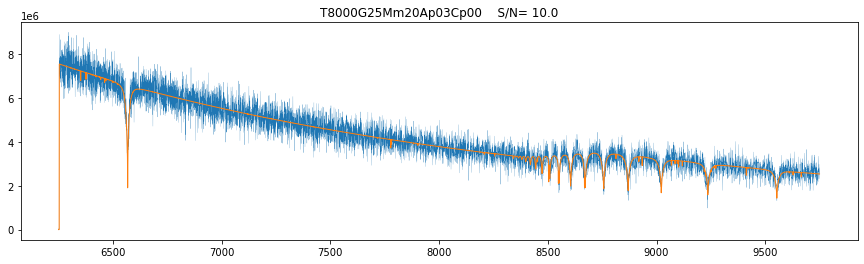

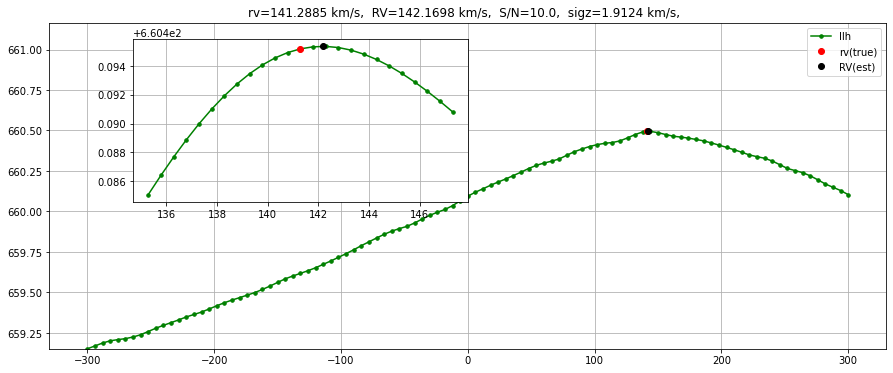

[[ 2.28903643e-06 -6.01175459e-07]
 [-6.01175459e-07  7.04007536e-02]]


In [14]:
#################################################################
# Run a quick test to get the velocity and the Fisher matrix
#################################################################
#------------------------------------------
# 2. pick a velocity and a noise level
# 3. run the test and plot the result
#------------------------------------------
rv  = 141.28845313 
NL  = 200

RV,F = testOneRV1(ss,temp,rv,NL);
ff = sp.linalg.inv(np.array(F))
print(ff)


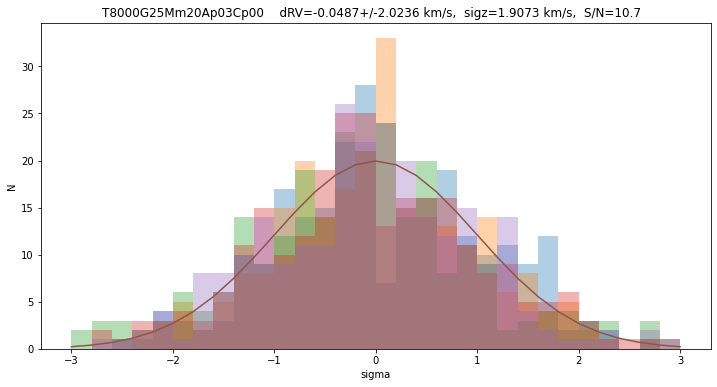

    ..time:  1156.3243145942688  sec


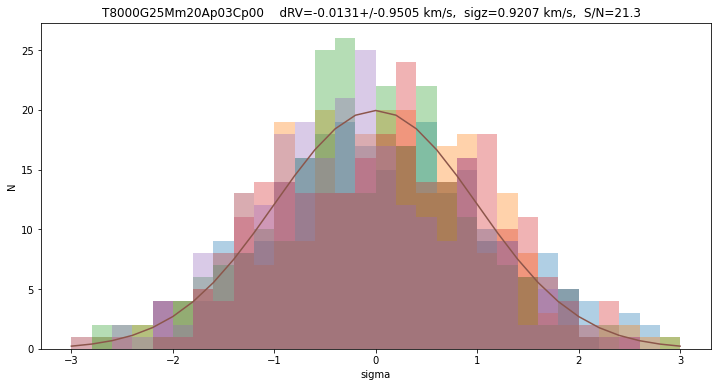

    ..time:  1113.830904006958  sec


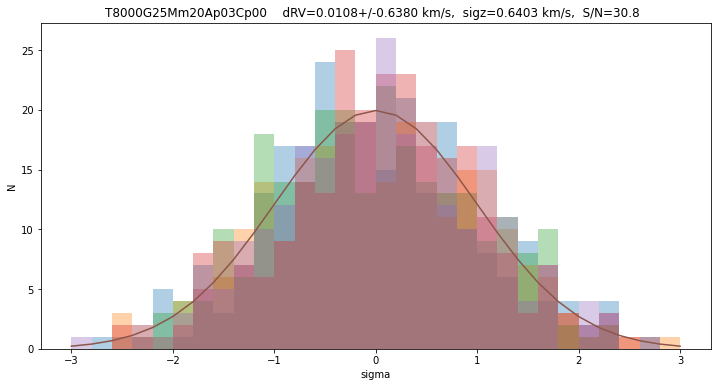

    ..time:  1141.5857951641083  sec


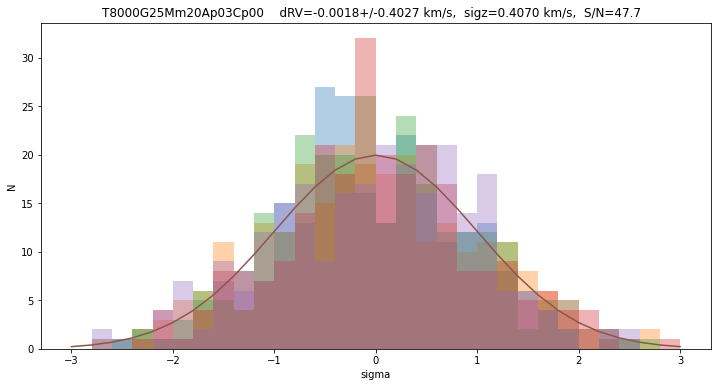

    ..time:  1108.5972781181335  sec


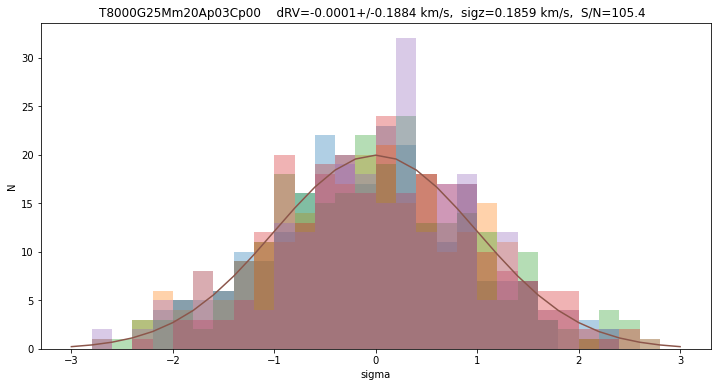

    ..time:  1091.9371399879456  sec
Total time:  5652.746798276901  sec


In [707]:
#--------------------------------------
# process one spectrum through several 
# SNRs and build a histogram of the 
# normalized velocity estimates
#--------------------------------------
N   = 250
NT  = 4
NV  = 5
#----------------------------
t0 = time.time()

for NL in nlarr:
    t1 = time.time()
    S  = getSigmaSim(NL,NV,N,NT,ss,T)
    Q  = mergeSims(S)
    showSigmaHisto(Q)
    t2 = time.time()
    print('    ..time: ',t2-t1,' sec')

getSigmaTemplate(rv,nlarr,ss,T)
t3 = time.time()  
print('Total time: ',t3-t0,' sec')

## 